<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/002_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained TensorFlow2 Object Detection For Inference on Test Images.

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Roboflow Workmark](https://i.imgur.com/L0n564N.png)

### **Setting up Colab :**

In [1]:
# What GPU do we have ?
!nvidia-smi

Fri Oct  9 09:58:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [2]:
# Clone the RetinaNet Repo
!git clone https://github.com/benihime91/pytorch_retinanet.git
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet
!echo "[   OK   ] Installed all depedencies "

#Update sys path to enclude the pytorch retinaet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

!echo "[   OK   ] Setup Done "

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 1892 (delta 89), reused 98 (delta 39), pack-reused 1730
Receiving objects: 100% (1892/1892), 57.68 MiB | 4.27 MiB/s, done.
Resolving deltas: 100% (1253/1253), done.
     |████████████████████████████████| 481kB 2.7MB/s 
     |████████████████████████████████| 829kB 5.0MB/s 
     |████████████████████████████████| 92kB 5.9MB/s 
     |████████████████████████████████| 276kB 11.3MB/s 
     |████████████████████████████████| 952kB 2.7MB/s 
[   OK   ] Installed all depedencies 
[   OK   ] Setup Done 


# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow.  This is a dataset of blood cells photos.  

There are 364 images across three classes: 
* WBC (white blood cells)
* RBC (red blood cells)
* Platelets. 


There are 4888 labels across 3 classes (and 0 null examples).


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [3]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
#curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://public.roboflow.com/ds/vYOavmoHyM?key=byxE8x2t11" > roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0    885      0  0:00:01  0:00:01 --:--:--   885
100 6087k  100 6087k    0     0  4556k      0  0:00:01  0:00:01 --:--:-- 4556k
Archive:  roboflow.zip
 extracting: train/BloodImage_00242_jpg.rf.007c73259d80a031ed7705cc0d1fa86c.jpg  
 extracting: train/BloodImage_00240_jpg.rf.02e03d6cdaa6a0c4446fbede5b024dd2.jpg  
 extracting: train/BloodImage_00320_jpg.rf.0162f52310ba3d29d7a1a9cd30a43488.jpg  
 extracting: test/BloodImage_00190_jpg.rf.03484116dcad7715c77d30654056fc54.jpg  
 extracting: valid/BloodImage_00017_jpg.rf.03e73d66a140b6b0fb97b3170af9ff27.jpg  
 extracting: valid/BloodImage_00377_jpg.rf.0312942b2d584915ce2498b70b4c7fd9.jpg  
 extracting: train/BloodImage_00196_jpg.rf.03390ec25911b1035cae7b7ea3b8245d.jpg  
 extracting: train/BloodImage_00256_jpg.rf.03ae10c8cb261253736684b6b1774dc4.jpg

In [4]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGES = "/content/train"
VALID_IMAGE = "/content/valid"
TEST_IMAGES = "/content/test"
#Path to where the xml annotations are stored
TRAIN_ANNOTATIONS = "/content/train"
VALID_ANNOTATIONS = "/content/valid"
TEST_ANNOTATIONS  = "/content/test"

In [5]:
import pandas as pd
from utils.pascal import convert_annotations_to_df
from PIL import Image
import cv2

pd.set_option("display.max_colwidth", None)

## **Generate csv file from XML Annotations:**

In [6]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOTATIONS, TRAIN_IMAGES, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOTATIONS, VALID_IMAGE, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOTATIONS, TEST_ANNOTATIONS, image_set="test")
!echo "[   DONE  ] DataFrames Generated !"

# removing annotations that are not valid annotations
!echo "[   INFO  ] Removing invalied annotations ... "
train_df = train_df[train_df.xmax > train_df.xmin]
train_df = train_df[train_df.ymax > train_df.ymin]

valid_df = valid_df[valid_df.xmax > valid_df.xmin]
valid_df = valid_df[valid_df.ymax > valid_df.ymin]

test_df = test_df[test_df.xmax > test_df.xmin]
test_df = test_df[test_df.ymax > test_df.ymin]

train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace =True, drop=True)

#save the csv files to memory
TRAIN_CSV = "/content/train/train_data.csv"
VALID_CSV = "/content/valid/valid_data.csv"
TEST_CSV  = "/content/test/test_data.csv"

train_df.to_csv(TRAIN_CSV, index=False)
!echo "[   DONE  ] Train csv files saved to {TRAIN_CSV} !"

valid_df.to_csv(VALID_CSV, index=False)
!echo "[   DONE  ] Valid csv files saved to {VALID_CSV} !"

test_df.to_csv(TEST_CSV, index=False)
!echo "[   DONE  ] Test csv files saved to {TEST_CSV} !"

[   DONE  ] DataFrames Generated !
[   INFO  ] Removing invalied annotations ... 


[10/09 10:00:02] numexpr.utils INFO: NumExpr defaulting to 2 threads.


[   DONE  ] Train csv files saved to /content/train/train_data.csv !
[   DONE  ] Valid csv files saved to /content/valid/valid_data.csv !
[   DONE  ] Test csv files saved to /content/test/test_data.csv !


### **CSV Files are as follows :**

In [7]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/BloodImage_00361_jpg.rf.509134ededd0bb5bfe892c081c8a8ee4.jpg,416,416,RBC,297,142,359,218,2
1,/content/train/BloodImage_00361_jpg.rf.509134ededd0bb5bfe892c081c8a8ee4.jpg,416,416,RBC,326,226,381,304,2
2,/content/train/BloodImage_00361_jpg.rf.509134ededd0bb5bfe892c081c8a8ee4.jpg,416,416,RBC,371,263,415,352,2
3,/content/train/BloodImage_00361_jpg.rf.509134ededd0bb5bfe892c081c8a8ee4.jpg,416,416,RBC,307,306,376,386,2
4,/content/train/BloodImage_00361_jpg.rf.509134ededd0bb5bfe892c081c8a8ee4.jpg,416,416,RBC,29,269,88,349,2


In [8]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/BloodImage_00109_jpg.rf.43f46103208703c3e95b1ae3dab79dc6.jpg,416,416,RBC,253,137,316,215,2
1,/content/valid/BloodImage_00109_jpg.rf.43f46103208703c3e95b1ae3dab79dc6.jpg,416,416,RBC,325,323,389,403,2
2,/content/valid/BloodImage_00109_jpg.rf.43f46103208703c3e95b1ae3dab79dc6.jpg,416,416,RBC,193,134,255,221,2
3,/content/valid/BloodImage_00109_jpg.rf.43f46103208703c3e95b1ae3dab79dc6.jpg,416,416,RBC,255,3,325,90,2
4,/content/valid/BloodImage_00109_jpg.rf.43f46103208703c3e95b1ae3dab79dc6.jpg,416,416,RBC,168,144,230,232,2


In [9]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/BloodImage_00160_jpg.rf.500f16e32681898ca1ce052ea0402c08.jpg,416,416,RBC,111,160,182,249,2
1,/content/test/BloodImage_00160_jpg.rf.500f16e32681898ca1ce052ea0402c08.jpg,416,416,RBC,261,186,333,275,2
2,/content/test/BloodImage_00160_jpg.rf.500f16e32681898ca1ce052ea0402c08.jpg,416,416,RBC,326,263,397,351,2
3,/content/test/BloodImage_00160_jpg.rf.500f16e32681898ca1ce052ea0402c08.jpg,416,416,RBC,320,55,391,143,2
4,/content/test/BloodImage_00160_jpg.rf.500f16e32681898ca1ce052ea0402c08.jpg,416,416,RBC,1,27,72,118,2


# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [10]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'Platelets', 'RBC', 'WBC']

##**Plot images with Bounding boxes over them**:

In [11]:
from utils import visualize_boxes_and_labels_on_image_array
import numpy as np

In [12]:
def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index
    """
    assert index <= len(dataframe), f"[  ERROR  ] Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs = dataframe.loc[dataframe.filename == fname]
    bbs  = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls = locs["labels"].values
    return fname, bbs, cls

### **Image from Train Data:**

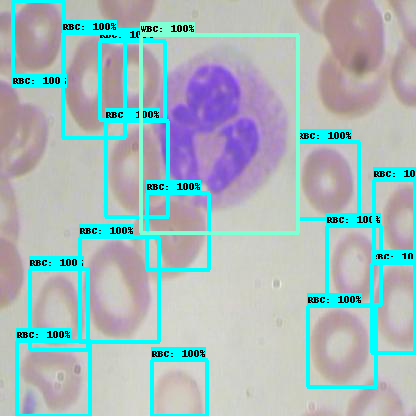

In [13]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(train_df, index=0)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

image

### **Image from Validation data:**

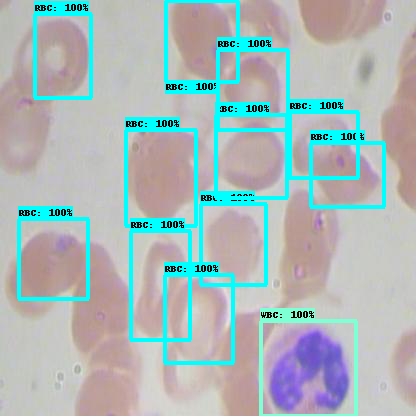

In [15]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(valid_df, index=50)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

image

###**Image from Test Data:**

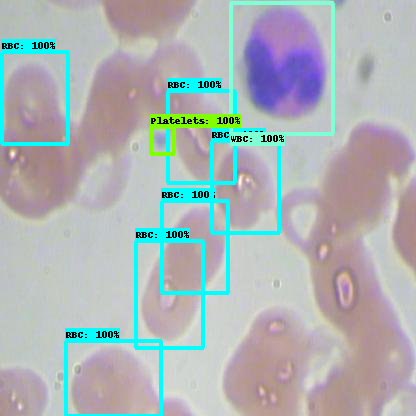

In [16]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(test_df, index=100)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :


In [17]:
#let's look at the config file
%cat /content/pytorch_retinanet/hparams.yaml

###################################################################
# CONFIG FILE TO INSTANTIATE THE LIGHTNING MODEL :
###################################################################

# ============================================================== #
# RETINANET MODEL PARAMETERS
# ============================================================== #
# set the parameters to be passed on to the retianet mode here
# NOTE: the full set of arguemnts can be found in `retinanet/config.py` .
model:
  backbone_kind: resnet50 # backbone of the model
  num_classes: 90 # number of classes (excluding the background class)
  freeze_bn: True # wether to freeze the backone of the model
  min_size: 800 # Size of the smallest side of the image during training
  max_size: 1600 # Maximum size of the side of the image during training

# ============================================================== #
# DATASETS AND DATALOADERS :
# ============================================================== #
# the datase

In [19]:
from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")
!echo "[  WORKING ] Writing Custom Configuration File .. "
# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
#specify kind of data to use
hparams.dataset.kind = "csv"
#Paths to the csv files
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV
# Dataset has 3 classes excluding the "__background__" class
hparams.model.num_classes = 3
#Changing optimizer paramters, 
#Scheduler can also be Optimized in the same way
hparams.optimizer = {
                "class_name": "torch.optim.SGD", 
                "params": {
                    "lr": 8e-03,
                    "momentum": 0.9,
                    "weight_decay" : 0.0001,
                    }
            }

# adding augmentations
hparams.transforms.append(
    {
        "class_name": "albumentations.ShiftScaleRotate",
        "params": {"p": 0.5},
    }
)

!echo "[   DONE   ] Configuration File : "
print(OmegaConf.to_yaml(hparams))

[  WORKING ] Writing Custom Configuration File .. 
[   DONE   ] Configuration File : 
model:
  backbone_kind: resnet50
  num_classes: 3
  freeze_bn: true
  min_size: 800
  max_size: 1600
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train/train_data.csv
  valid_paths: /content/valid/valid_data.csv
  test_paths: /content/test/test_data.csv
dataloader:
  train_bs: 2
  valid_bs: 30
  test_bs: 30
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.008
    momentum: 0.9
    weight_decay: 0.0001
scheduler:
  class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
  params:
    mode: min
    factor: 0.1
    patience: 8
  interval: 1
  frequency: epoch
  monitor: val_loss



#**Instantiate Lightning-Module and Lightning-Trainer**

In [20]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import *
from pytorch_lightning.callbacks import *
from model import RetinaNetModel, LogCallback

# seed so that results are reproducible
pl.seed_everything(123)

123

##**Load in the Lighning-Module using the hparams file modified above :**

In [21]:
# Instantie lightning-module
litModel = RetinaNetModel(hparams=hparams)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



[10/09 10:05:05 retinanet.models]: BACKBONE : resnet50
[10/09 10:05:05 retinanet.models]: INPUT PARAMS : MAX_SIZE=1600, MIN_SIZE=800
[10/09 10:05:05 retinanet.models]: NUM CLASSES : 3


## **Load in the Lighning-Trainer :**

In [22]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

# Wandb logger
# can use any other logger
save_dir = "/content/logs"
LOGGER = TensorBoardLogger(save_dir="/content/logs")
# Learning-rate Logger
LR_LOGGER = LearningRateLogger(logging_interval="step")

# Model Checkpoint
fname =f"/content/checkpoints/"
os.makedirs(fname, exist_ok=True)
CHECKPOINT_CALLBACK = ModelCheckpoint(fname, mode="min", monitor="val_loss", save_top_k=3,)

# callback for early-stopping
EARLY_STOPPING_CALLBACK = EarlyStopping(mode="min", monitor="val_loss", patience=10,)

# instantiate trainer with arguments from above
trainer = Trainer(precision=16, 
                  max_epochs=50,
                  num_sanity_val_steps=0,
                  gpus=1, 
                  logger=[LOGGER],
                  early_stop_callback=EARLY_STOPPING_CALLBACK, 
                  checkpoint_callback=CHECKPOINT_CALLBACK,
                  callbacks=[LogCallback(), LR_LOGGER], 
                  weights_summary=None,
                  terminate_on_nan=True, 
                  benchmark=True,
                  )

GPU available: True, used: True
[10/09 10:06:00] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[10/09 10:06:00] lightning INFO: TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[10/09 10:06:00] lightning INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[10/09 10:06:00] lightning INFO: Using native 16bit precision.


# **Train Custom Pytorch Retinanet Object Detector**:

To train using pytorch-lightning we just need to run `trainer.fit(litModel)`.

Properties (like data, optimzier, scheduler) are already defined in the `litModel` which was loaded using the custom modified `hparams` file.


While `trainer` handles properties like Callbacks, fp_16 training, GPU training ...

In [ ]:
!echo "[   START   ] START TRAINING ... "
trainer.fit(litModel)
!echo "[    END    ] TRAINING COMPLETE ! "
!echo "[    INFO   ] RUN  : %tensorboard --logdir {save_dir} to view TensorBoard Logs "

[   START   ] START TRAINING ... 
[10/09 10:07:12 retinanet.models]: DATASET_KIND : csv
[10/09 10:07:20 retinanet.models]: OPTIMIZER_NAME : SGD
[10/09 10:07:20 retinanet.models]: LEARNING_RATE: 0.008
[10/09 10:07:20 retinanet.models]: WEIGHT_DECAY: 0.0001
[10/09 10:07:20 retinanet.models]: LR_SCHEDULER_NAME : ReduceLROnPlateau
[10/09 10:07:21 retinanet.models]: MAX_EPOCHS : 50
[10/09 10:07:22 retinanet.models]: Training on 255 images
[10/09 10:07:22 retinanet.models]: Training from iteration 0 : 


### **Open TensorBoard Logs :**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {save_dir}

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
!ls checkpoints/

In [ ]:
# Evaluations results on the test/ validation dataset(if test dataset is not given)
# using COCO API
!echo "[   START   ] START EVALUATION OF MODEL ON TEST IMAGE USING COCO-API ... "
trainer.test(litModel)
!echo "[    END    ] DONE EVALUATING MODEL ON TEST IMAGE USING COCO-API ! "

# **Export the model weights** :

In [ ]:
import torch

PATH = f"/content/trained_weights.pth"
torch.save(litModel.model.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
from retinanet import Retinanet

state_dict = torch.load(PATH)

MODEL = Retinanet(num_classes=hparams.model.num_classes, backbone_kind=hparams.model.backbone_kind)
MODEL.load_state_dict(state_dict)

# **Run Inference on Test Images with Custom PyTroch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import visualize_boxes_and_labels_on_image_array

@torch.no_grad()
def get_preds(path, threshold=0.6, nms_threshold=0.5):
    """
    Generates predictions on the given image from the given path.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([A.ToFloat(max_value=255.0, always_apply=True),
                                  ToTensorV2(always_apply=True)
                                  ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"]
    MODEL.score_thres = threshold
    MODEL.nms_thres = nms_threshold
    PREDICTIONS = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def filter_preds(ps):
    """
    Filters the predictions using given threshold.
    """
    scores = ps["scores"]
    labels = ps["labels"]
    boxes = ps["boxes"]
    return scores.numpy(), labels.numpy(), boxes.numpy()


def detect(image_path, threshold=0.6, nms_threshold=0.5):
    """
    Generate detections on the image that is present in 
    the given image path

    Args:
        image_path: Path to the input Image
        threshold: Score threshold to filter predictions
        nms_threshold: NMS threshold

    Returns: a PIL image containg the original Image and
             bounding boxes draw over it.
    """
    
    # visualize_boxes_and_labels_on_image_array function
    # expects the pixels values of the image to be in 
    # range [0,1] so be divide the loaded image by 255.0
    # to noramlize the co-ordinates
    # load the image as numpy array
    image = Image.open(image_path)
    image = np.array(image) / 255.
    
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold, nms_threshold)
    # Filter predictions
    scores, labels, boxes = filter_preds(preds)
    # Draw all the bounding boxes over the Image
    im = visualize_boxes_and_labels_on_image_array(
                image,
                boxes,
                labels,
                scores,
                LABEL_MAP,
                )
    
    return im

In [ ]:
REAL_IMAGE, REAL_BOXES, REAL_LABELS = grab_bbs_(test_df, index=10)
REAL_IMAGE = Image.open(REAL_IMAGE)
REAL_IMAGE = np.array(REAL_IMAGE) / 255.

#draw boxes over the image
REAL_IMAGE = visualize_boxes_and_labels_on_image_array(
                image=REAL_IMAGE,
                boxes=REAL_BOXES, 
                scores=None, 
                classes=REAL_LABELS,
                label_map=LABEL_MAP,
)

REAL_IMAGE

PATH = test_df.filename[10]
THRESHOLD = 0.7
NMS_THRSHOLD = 0.5


PRED_IMAGE = detect(PATH, THRESHOLD, NMS_THRSHOLD)

In [ ]:
!echo "[ INFERENCE ] ORIGINAL"

REAL_IMAGE

In [ ]:
!echo "[ INFERENCE ] PREDICTIONS "

PRED_IMAGE